### 1. Prepare input and target data for model

In [1]:
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

# load the dataset
def load_dataset(filename, column):
	# load the dataset as a pandas DataFrame
	df = read_csv(filename)
	# split into input (X) and output (y) variables & convert to numPy array
	X = df.drop(column, axis = 1).values
	y = df[column].values
	return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
		
	# scale dataset
	scaler = preprocessing.MinMaxScaler()
	X_train_rescaled = scaler.fit_transform(X_train_enc)
	X_test_rescaled = scaler.fit_transform(X_test_enc)
	return X_train_rescaled, X_test_rescaled

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

# load the dataset
X, y = load_dataset('mushrooms.csv', 'class')
# split into train and test sets; 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

### 2. Compute Logistic Regression and accuracy

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot

# define how many features to select
number_of_features = 10
print('number of selected features: ', number_of_features, '\n')

# Feature reduction function
def select_features(X_train, y_train, X_test, reduction_func):
 fs = SelectKBest(score_func=reduction_func, k=number_of_features)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

####ALL FEATURES####

# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_enc, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_enc)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy using ALL features: %.2f' % (accuracy*100))

####CHI2 FEATURES####

# chi2 feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc, chi2)

# chi2 stats
#for i in range(len(fs.scores_)):
# print('Feature %d: %f' % (i, fs.scores_[i]))
#pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
#pyplot.show()

# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy using Chi2: %.2f' % (accuracy*100))

####MUTUAL INFORMATION FEATURES####

# mutual information feature selection
X_train_fs, X_test_fs, fs= select_features(X_train_enc, y_train_enc, X_test_enc, mutual_info_classif)

# mutual information stats
#for i in range(len(fs.scores_)):
# print('Feature %d: %f' % (i, fs.scores_[i]))
#pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
#pyplot.show()

# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy using Mutual Information: %.2f' % (accuracy*100))

number of selected features:  10 

Accuracy using ALL features: 94.77
Accuracy using Chi2: 93.35
Accuracy using Mutual Information: 91.75


### 3a. Compute accuracy of Neural Network using Chi Squared Features

#### 3a1. Hyperparameter tuning

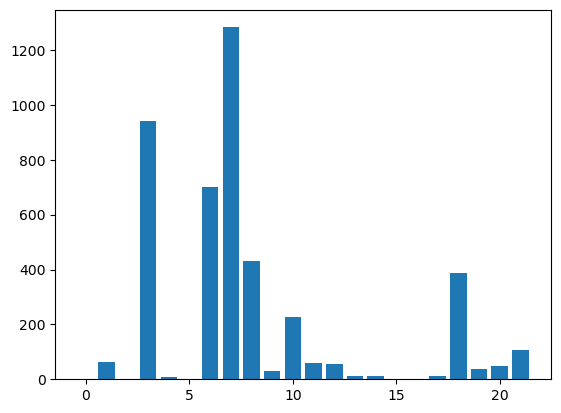

Best parameters:  {'hidden_layer_sizes': (5, 7), 'learning_rate_init': 0.3, 'max_iter': 500}


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV

# define how many features to select
number_of_features = 10

# feature selection
def select_features_chi2(X_train, y_train, X_test):
 fs = SelectKBest(score_func=chi2, k=number_of_features)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features_chi2(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
#for i in range(len(fs.scores_)):
# print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()


# Performing some hyperparameter tuning (it can take aorund 3 minutes)
max_iterations = [500,800,1000]
hidden_layer_siz = [(5, 7), (7, 13), (13, 10)]
learning_rates = 0.15 * np.arange(1, 3)
param_grid = dict(learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations)

#set model
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.3, batch_size = 100, hidden_layer_sizes = (12, 3), max_iter = 500)

# For Grid Search
grid = GridSearchCV(estimator = mlp, param_grid = param_grid)

# Train the model with grid search
grid_result = grid.fit(X_train_fs, y_train_enc)

# Print the best hyperparameters
print("Best parameters: ", grid.best_params_)



#### 3a2. Fitting the model with the tuned hyperparameters

In [19]:
#set model with the best hyperparameters that we just computed
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = grid_result.best_params_["learning_rate_init"], batch_size = 100, hidden_layer_sizes = grid_result.best_params_["hidden_layer_sizes"], max_iter = grid_result.best_params_["max_iter"])

mlp.fit(X_train_fs, y_train_enc)
mlp.predict(X_test_fs)

accuracy = accuracy_score(y_test_enc, pred)
print('Accuracy: %.2f' % (accuracy*100))
print("Classification Report : ")
print(classification_report(y_test_enc, pred))


Accuracy: 99.69
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       820
           1       0.99      1.00      1.00       805

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



#### 3a3. k-fold cross validation

In [26]:
# Using sklearn function cross_validate()

from sklearn.model_selection import cross_validate

CV = cross_validate(mlp, X_test_fs, y_test_enc, cv=10, scoring=['accuracy', 'neg_mean_squared_error'])

print('MSE')
print(-1*CV['test_neg_mean_squared_error'])
print('Average MSE = ', sum(-1 * CV['test_neg_mean_squared_error']) / len(CV['test_neg_mean_squared_error']))


MSE
[0.01226994 0.02453988 0.04294479 0.00613497 0.01226994 0.
 0.00617284 0.         0.00617284 0.01234568]
Average MSE =  0.012285086722714536
